In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
scv.settings.verbosity = 0
# import unitvelo as utv
# import gseapy as gp
import multivelo as mv

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append('/data/nelkazwi/code/UniTVelo-ATAC/unitvelo')
from supplement.fitting_genes_regions import average_over_intervals, compute_alpha_atac, region_unspliced_kinetics
from pl.pl import gene_weights_plots, get_scatter_markers, region_kinetic_plot
from supplement.eval_utils import KNN_eval

In [4]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [28]:
save_dir = '0905_172934'
data_set = '/E18_mouse_brain_10X/Mode_1/checkpoints/VelocityDemo'
path_result = '/data/nelkazwi/RNA_velo/Unitvelo_atac/'+data_set+'/'#/checkpoints/VelocityDemo/'
adata = sc.read(path_result+str(save_dir)+"/model_last.h5ad")
adata_atac = sc.read(path_result+str(save_dir)+"/model_last_atac.h5ad")
B = np.loadtxt('/data/nelkazwi/RNA_velo/Unitvelo_atac/HSPC/B_mouse_brain.txt', delimiter=',')
all_clusters = ['Upper Layer',
                'Deeper Layer',
                'V-SVZ',
                'RG, Astro, OPC',
                'Ependymal cells',
                'IPC',
                'Subplate']
adata.obs['celltype'] = adata.obs['celltype'].cat.reorder_categories(all_clusters)

In [5]:
save_dir = '0724_103433'
data_set = 'HSPC/Mode_1'
path_result = '/data/nelkazwi/RNA_velo/Unitvelo_atac/'+data_set+'/checkpoints/VelocityDemo/'
adata = sc.read(path_result+str(save_dir)+"/model_last.h5ad")
adata_atac = sc.read(path_result+str(save_dir)+"/model_last_atac.h5ad")
B = np.loadtxt('/data/nelkazwi/RNA_velo/Unitvelo_atac/HSPC/B.txt', delimiter=',')

In [6]:
alpha_atac,adata = compute_alpha_atac(adata, adata_atac, B)


In [7]:
u_dots = adata.layers['u_derrivative']
u_dot_atac = adata.layers['u_atac']
wr = adata.varm["fit_region_weights"]
gene_names = adata.var_names

In [8]:
alpha_unit = u_dots + adata.layers['Pred_u']*adata.var['fit_beta'].values

In [9]:
alpha_atac_ = alpha_atac[:,u_dots.sum(axis=0) != 0]
alpha_unit_ = alpha_unit[:,u_dots.sum(axis=0) != 0]

In [10]:
c_scores = np.zeros(alpha_atac.shape[1])
for i in np.arange(0, alpha_atac.shape[1]):
 c_scores[i] = np.corrcoef(alpha_atac[:,i],alpha_unit[:,i])[0,1]

In [11]:
adata_ = adata[:,u_dots.sum(axis=0) != 0]

In [14]:
cu_scores = np.zeros(alpha_atac_.shape[1])
for i in np.arange(0, alpha_atac_.shape[1]):
 cu_scores[i] = np.corrcoef(alpha_atac_[:,i],adata_.layers['Mu'][:,i])[0,1]

In [26]:
# u_dots =u_dots[:,adata.var["velocity_genes"]]
# u_dot_atac = u_dot_atac[:,adata.var["velocity_genes"]]
# wr = wr[adata.var["velocity_genes"],:]
# gene_names = gene_names[adata.var["velocity_genes"]]

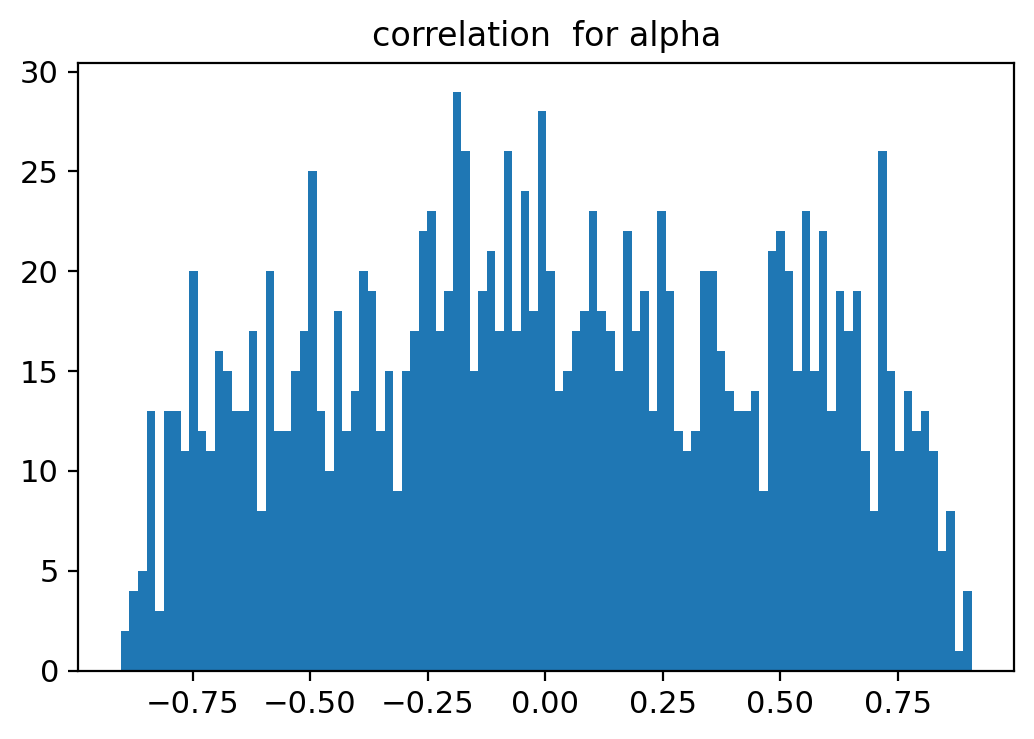

In [12]:
plt.hist(c_scores,bins = 100)
plt.title('correlation  for alpha')
plt.show()

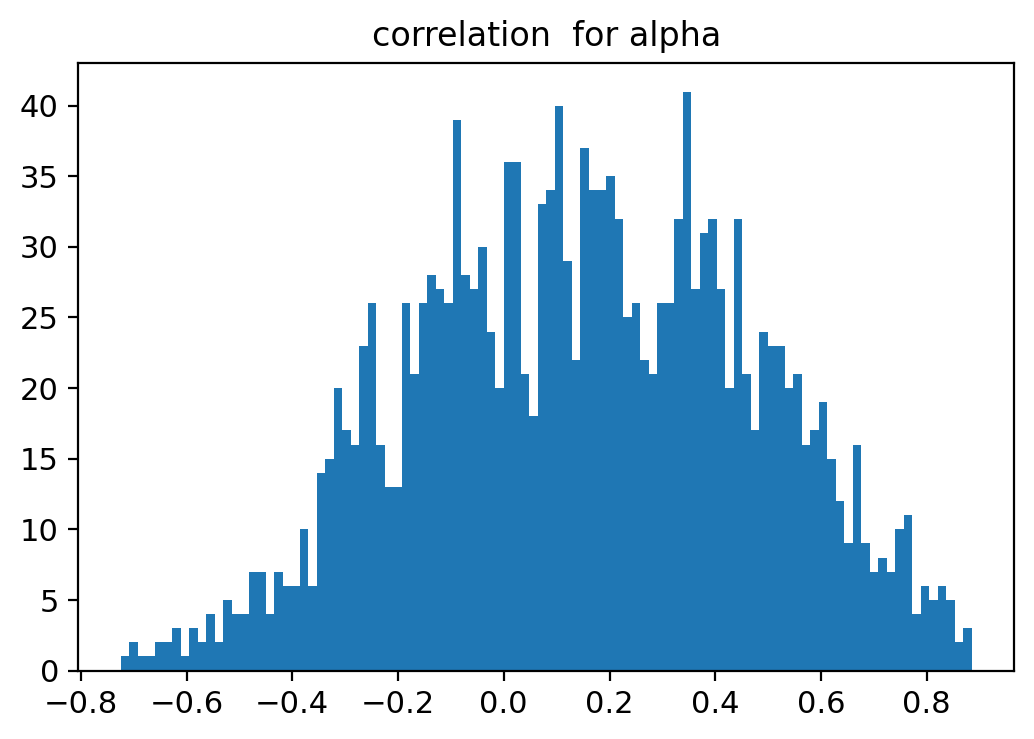

In [16]:
plt.hist(cu_scores,bins = 100)
plt.title('correlation  for alpha')
plt.show()

In [13]:
threshold = 0.3
x = np.where(c_scores>threshold)[0]

In [12]:
# u_dots_ = u_dots[:,u_dot_atac.sum(axis=0) != 0]
# u_dot_atac_ = u_dot_atac[:,u_dot_atac.sum(axis=0) != 0]
# wr = wr[u_dot_atac.sum(axis=0) != 0,:]
# gene_names = gene_names[u_dot_atac.sum(axis=0) != 0]

In [16]:
c = np.where(np.log(wr)!=0)[1]
r = np.where(np.log(wr)!=0)[0]

In [17]:
c_u_scores = np.zeros(u_dot_atac.shape[1])
for i in np.arange(0, u_dot_atac.shape[1]):
 c_u_scores[i] = np.corrcoef(u_dot_atac[:,i],u_dots[:,i])[0,1]

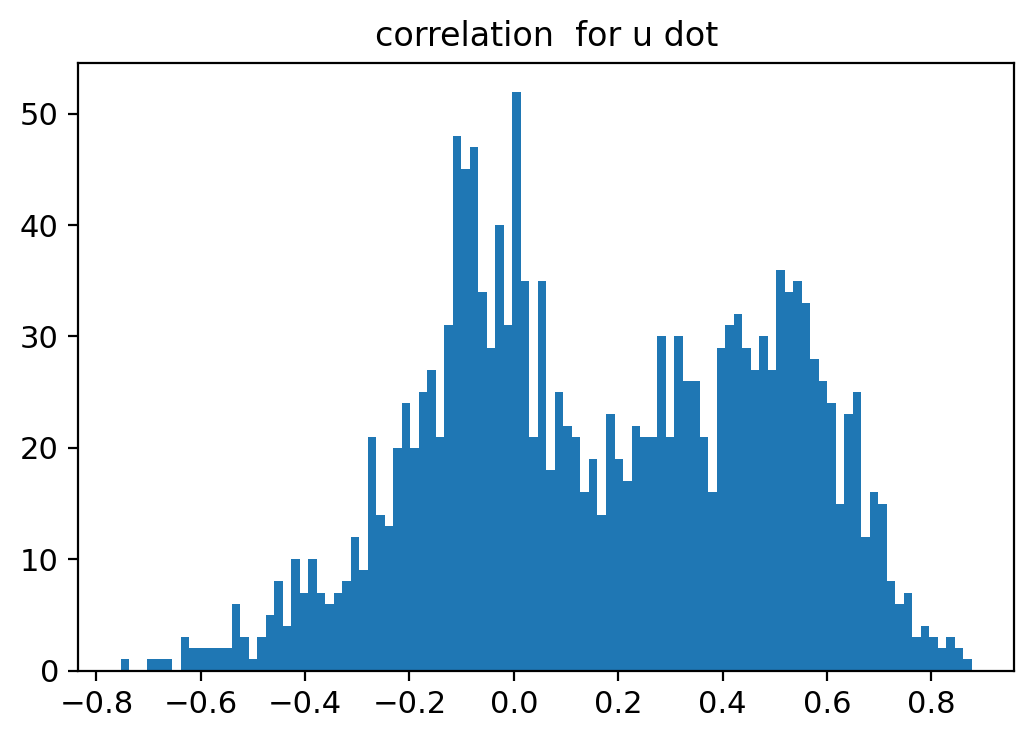

In [18]:
plt.hist(c_u_scores,bins = 100)
plt.title('correlation  for u dot')
plt.show()


In [28]:
threshold = 0.4
x = np.where(c_u_scores>threshold)[0]
c_u_scores_ = c_u_scores[x]


In [34]:
gene_list = []
for i, g in enumerate(x):
 #print(g, gene_names[g], wr[g,c[r == g]].shape[0], wr[g,c[r == g]], c_u_scores_[i])
 gene_list.append(gene_names[g])


In [35]:
len(gene_list)

483

In [43]:
enr_GO = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['GO_Biological_Process_2023'],#
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                  cutoff=1
                )

ax = gp.dotplot(enr_GO.res2d, cmap='viridis_r',size = 15,  figsize=(10,10), cutoff = 0.3)#, show_ring=True,  cutoff=0.002
#plt.tight_layout() 
fig_path = '/data/nelkazwi/RNA_velo/Unitvelo_atac/CRAK_Velo_fig/'
# plt.savefig(fig_path+'GO_HSPC.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig(fig_path+'GO_HSPC.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
genes_list = enr_GO.results['Genes'][0].split(';')
genes_list = [gene.capitalize() for gene in genes_list]
genes_list

In [16]:
adata_mv = sc.read_h5ad("/data/nelkazwi/RNA_velo/Unitvelo_atac/HSPC/multivelo_result_fig5.h5ad")
#adata = sc.read_h5ad("/data/nelkazwi/RNA_velo/Unitvelo_atac/HSPC/Mode_1/checkpoints/VelocityDemo/HSPC_alpha_test.h5ad")
alpha_atac,adata = compute_alpha_atac(adata, adata_atac, B)
adata.uns["celltype_colors"] = adata_mv.uns["leiden_colors"]
adata.obsm["X_umap"] = adata_mv.obsm["X_umap"]


# path = "/data/nelkazwi/RNA_velo/Unitvelo_atac/unitvelo_alone/HSPC/"
# adata_unv = sc.read_h5ad(path+'unitvelo_fit_data.h5ad')
# adata_unv.uns["celltype_colors"] = adata_mv.uns["leiden_colors"]
# adata_unv.obsm["X_umap"] = adata_mv.obsm["X_umap"]

In [30]:

adata_mv = sc.read_h5ad('/data/nelkazwi/RNA_velo/Unitvelo_atac/E18_mouse_brain_10X/Multivelo_mouse_brain_demo/multivelo_result_2.h5ad')
adata.uns["celltype_colors"] = adata_mv.uns["celltype_colors"]
adata.obsm["X_umap"] = adata_mv.obsm["X_umap"]

In [25]:
gene_list_ = gene_list

In [32]:
len(gene_list)

43

In [67]:
gene_list_ =['Fabp7', 'Mgat4c', 'Sgo1', 'Sox8']# [ 'INTU','PAX6','MSI2','SCN2A', "Eomes", ] #,'NFIA','Grin2b','EMX2',
gene_list_ = [gene.capitalize() for gene in gene_list_]

In [ ]:
gene_list_ = ['AZU1','HDC','KLF1', 'PXK', 'IL6R','PDZD8','ADCY6','HLF','STOM' ]
gene_weights_plots(gene_list_,adata, adata_atac)

In [13]:
#gene_list_ = ['PRAM1','GATA2','SLC22A4','ITGA2B',"KLF1" ]
#gene_list_ = ['AZU1','HDC','KLF1', 'PXK', 'IL6R','PDZD8','ADCY6','HLF','ADCY6','STOM' ]
gene_list_ = ['HDC', 'ADCY6', 'STOM']

In [10]:
gene_list_ = ['Tle4','Fabp7','Ccnd2']#'Msi2',

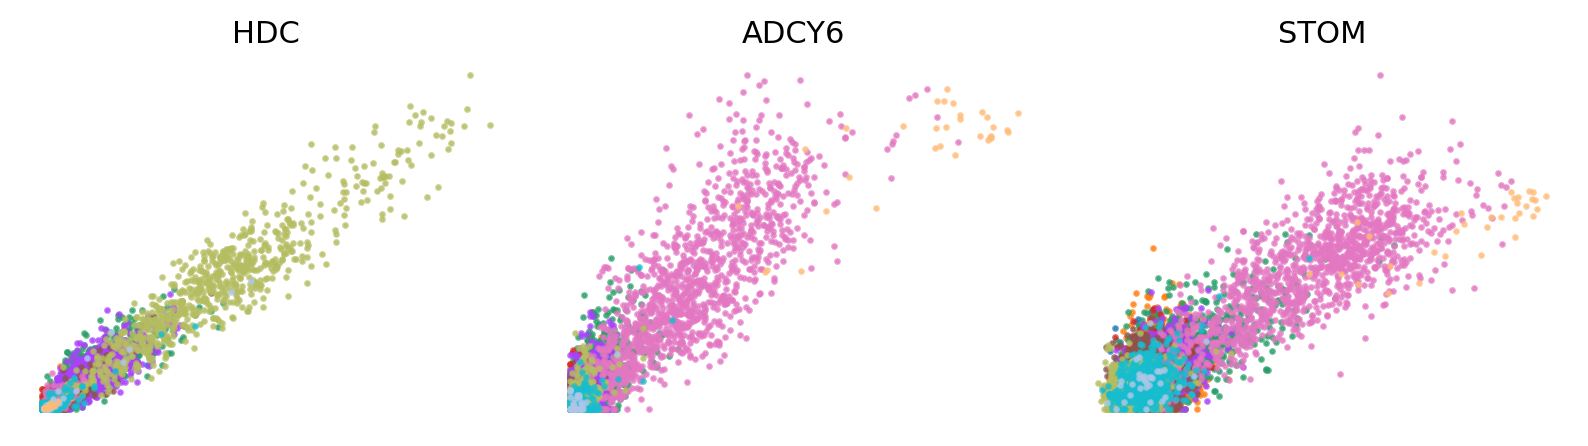

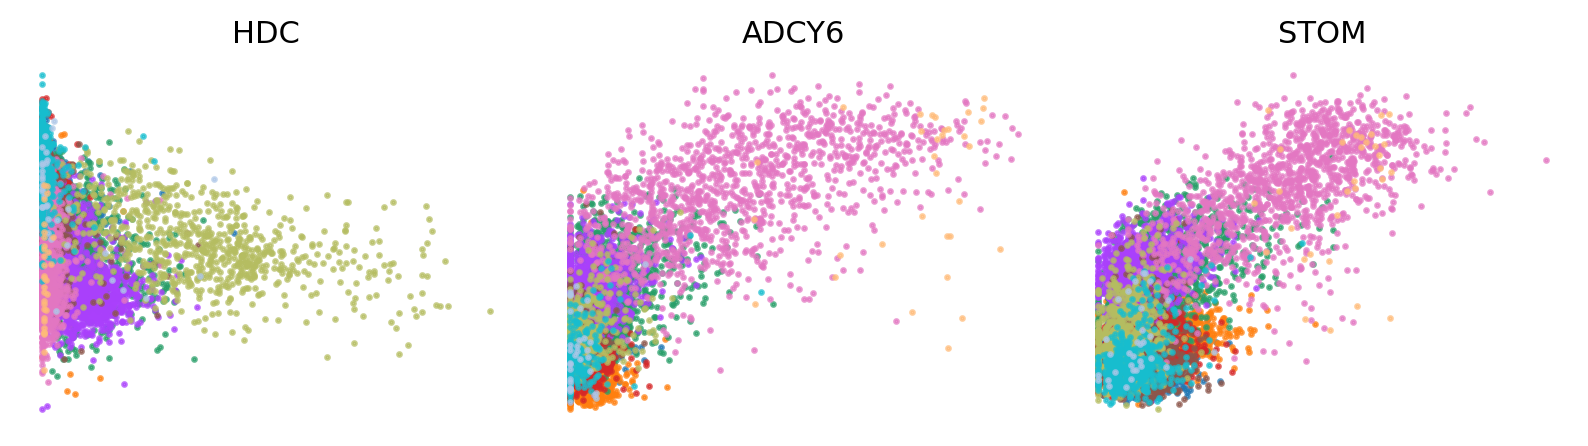

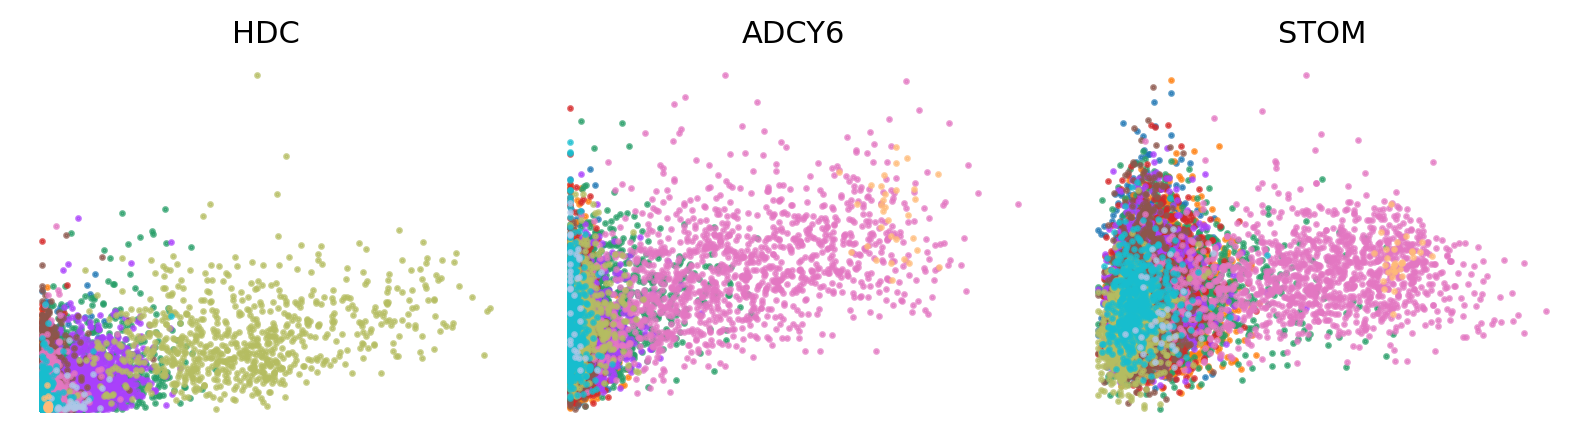

In [16]:
fig_path = '/data/nelkazwi/RNA_velo/Unitvelo_atac/CRAK_Velo_fig/'
mv.scatter_plot(adata, gene_list_, color_by='celltype', by='us',  axis_on=False, frame_on=False)
# plt.savefig(fig_path+'us_mouse_brain.png', dpi=300)

adata.layers["ATAC"] = alpha_atac
mv.scatter_plot(adata, gene_list_, color_by='celltype', by='cu',  axis_on=False, frame_on=False)
# plt.savefig(fig_path+'cu_CRAK_Velo_mouse_brain.png', dpi=300)

mv.scatter_plot(adata_mv, genes=gene_list_, color_by="leiden", by='cu', show_anchors=False, axis_on=False, frame_on=False)
# plt.savefig(fig_path+'cu_Multivelo_mouse_brain.png', dpi=300)

In [56]:
w = np.multiply(adata.varm["fit_region_weights"],B.T )
c_ = np.where(w!=0)[1]
r_ = np.where(w!=0)[0]

In [57]:
def region_unspliced_kinetics(adata, adata_atac, B, gene_name, interval = 0.05):

    w = np.multiply(adata.varm["fit_region_weights"],B.T )
    c = np.where(w!=0)[1]
    r = np.where(w!=0)[0]

    gene_number = np.where(adata.var_names == gene_name)[0][0]
    r_g = adata.varm["fit_region_weights"][gene_number, c[r == gene_number]]

    phi_r = adata_atac.obsm["cisTopic"][:, c[r == gene_number]]

    if phi_r.shape[1] != 0:

        time = np.zeros([phi_r.shape[1],int(1/interval)])
        c = np.zeros([phi_r.shape[1],int(1/interval)])

        for i in np.arange(0,phi_r.shape[1]):
            time[i,:], c[i,:] = average_over_intervals(r_g[i]*phi_r[:,i],adata.obs["latent_time"], interval)

        t, u_avg = average_over_intervals(adata.layers["Mu"][:,gene_number],
                                                adata.obs["latent_time"], interval)
        
        return time, c, u_avg
    
    else:
        print('No regions associated to '+str(gene_name)+" is found in the dataset")

In [25]:
adata

AnnData object with n_obs × n_vars = 11605 × 2000
    obs: 'cell_id', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'latent_time'
    var: 'Accession', 'chrom', 'chromEnd', 'chromStart', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_r2', 'scaling', 'velocity_genes', 'fit_vars', 'fit_varu', 'fit_gamma', 'fit_beta', 'fit_offset', 'fit_a', 'fit_t', 'fit_h', 'fit_intercept', 'fit_etta', 'fit_sr2', 'fit_ur2'
    uns: 'basis', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'fit_region_weights'
    layers: 'Ms', 'Mu', 'Mu_scale', 'Pred_s', 'Pred_u', 'ambiguous', 'fit_t', 'matrix', 'spliced', 'u_atac', 'u_derrivative', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

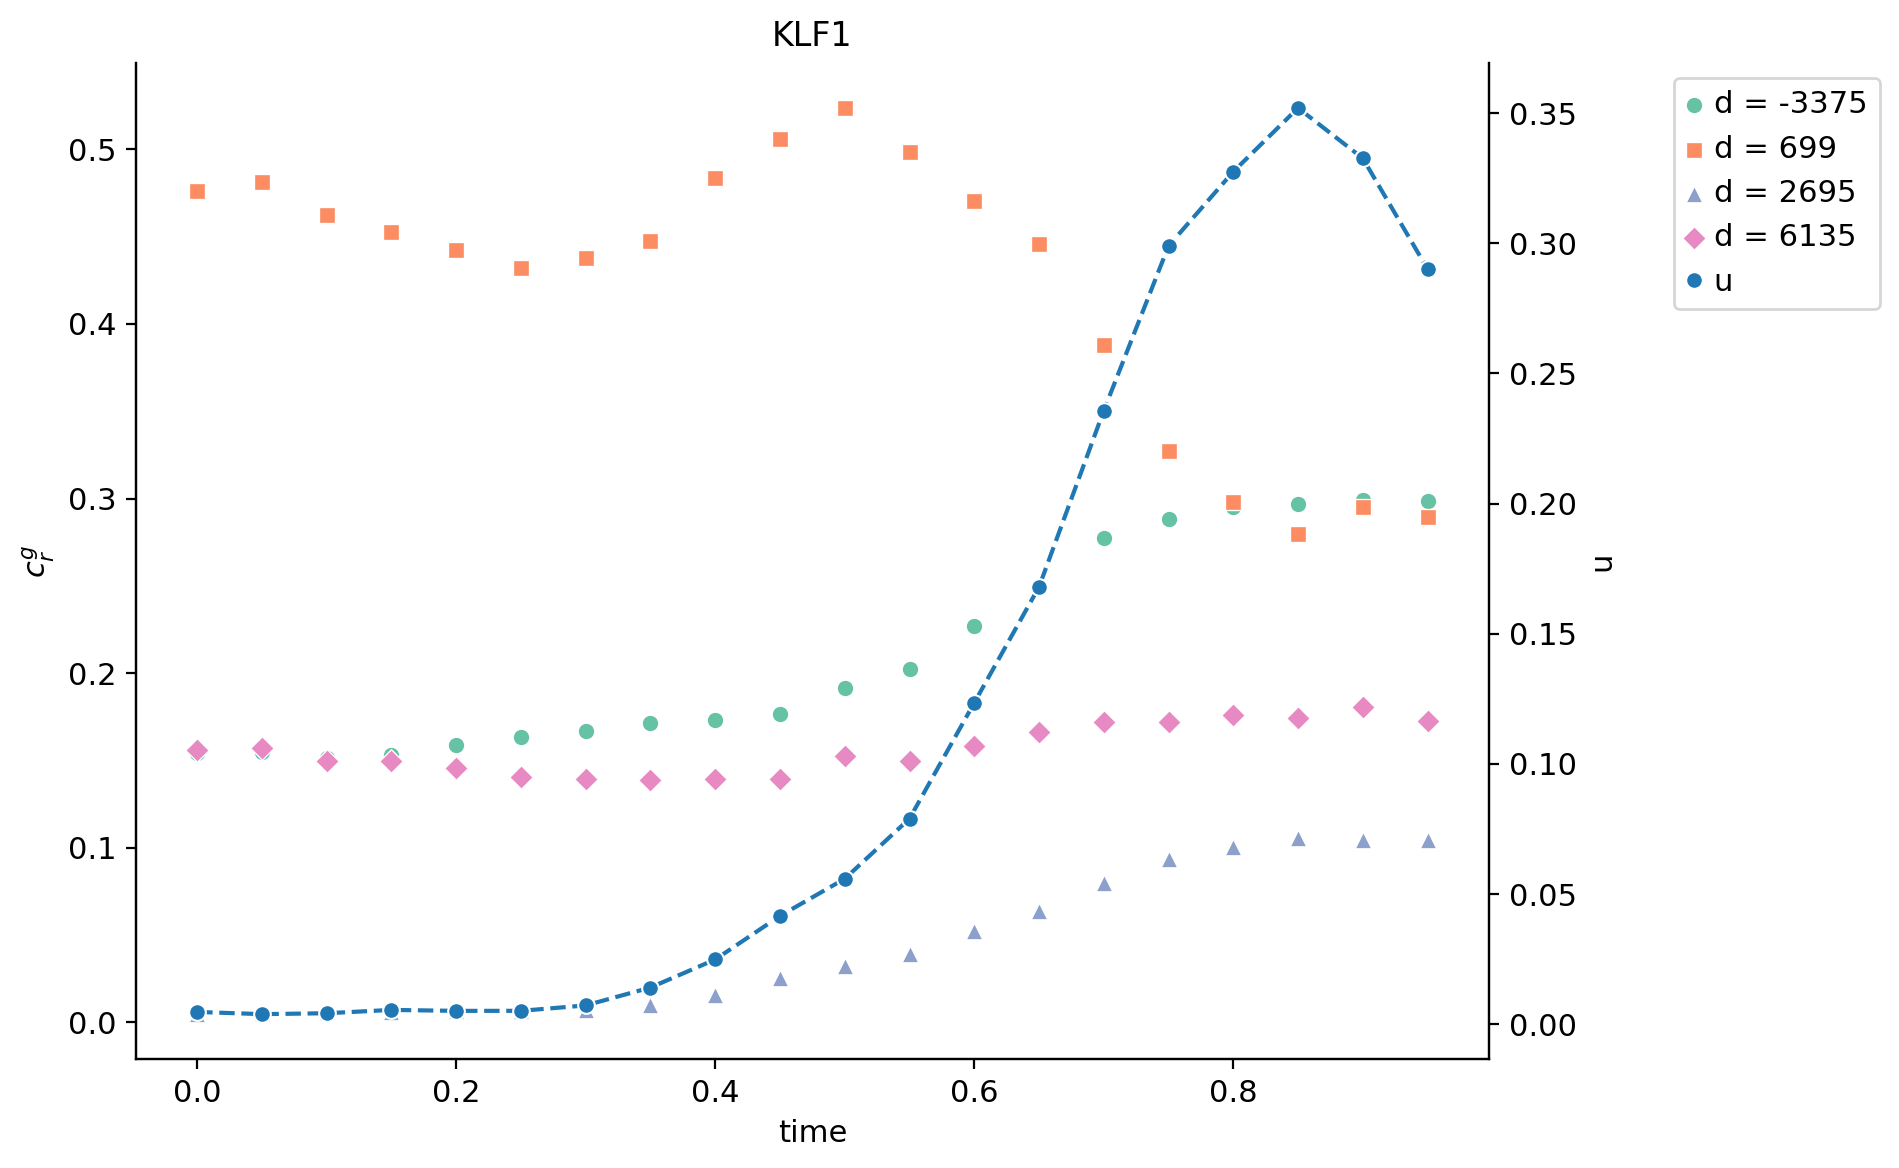

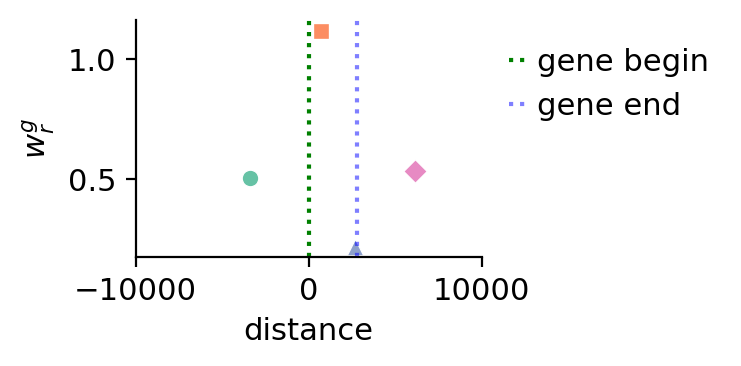

In [58]:
gene_name = 'KLF1'
time, c, u_avg = region_unspliced_kinetics(adata, adata_atac, B, gene_name, interval = 0.05)
region_kinetic_plot(adata,adata_atac,gene_name, time, c, u_avg,B)

In [16]:
gene_name =  "KLF1"

    
gene_number = np.where(adata.var_names == gene_name)[0][0]
r_g = adata.varm["fit_region_weights"][gene_number, c_[r_ == gene_number]]

phi_r = adata_atac.obsm["cisTopic"][:, c_[r_ == gene_number]]

phi_r.shape

(11605, 4)

In [17]:
interval_length = 0.05

t = np.zeros([phi_r.shape[1],int(1/interval_length)])
p = np.zeros([phi_r.shape[1],int(1/interval_length)])

for i in np.arange(0,phi_r.shape[1]):
    t[i,:], p[i,:] = average_over_intervals(r_g[i]*phi_r[:,i],adata.obs["latent_time"], interval_length)

t_, p_u = average_over_intervals(adata.layers["Mu"][:,gene_number],
                                        adata.obs["latent_time"], 0.05)
    

In [18]:
import sys
import importlib

# Clear the module from cache
sys.modules.pop('pl.pl', None)

# Reload the module
importlib.import_module('pl.pl')

from pl.pl import gene_weights_plots, region_kinetic_plot

%load_ext autoreload
%autoreload 2

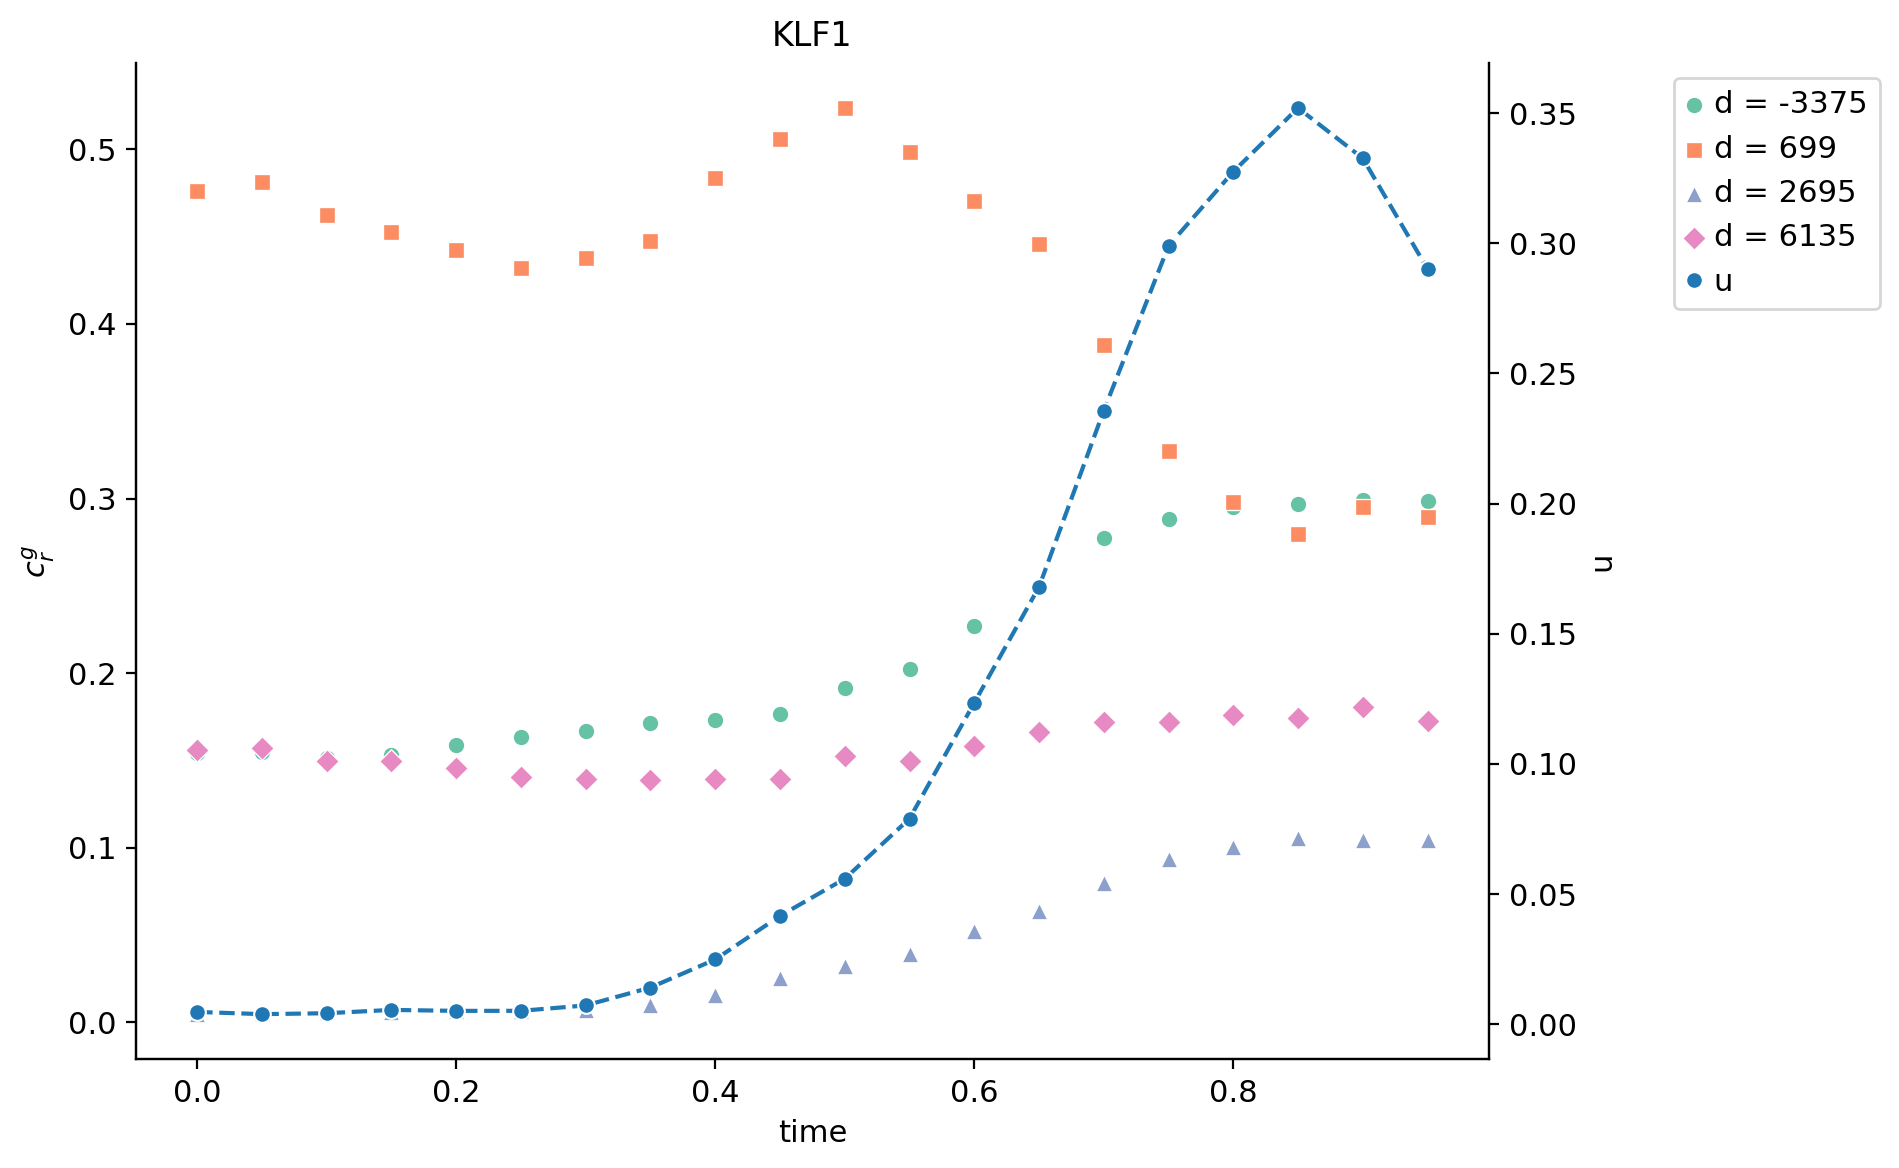

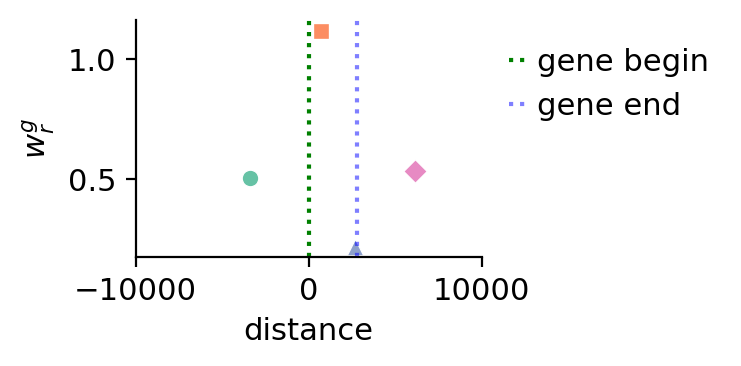

In [19]:
fig_path = '/data/nelkazwi/RNA_velo/Unitvelo_atac/CRAK_Velo_fig/'
region_kinetic_plot(adata,adata_atac,gene_name, t, p, p_u,B,
                     save_fig=False, path=fig_path)

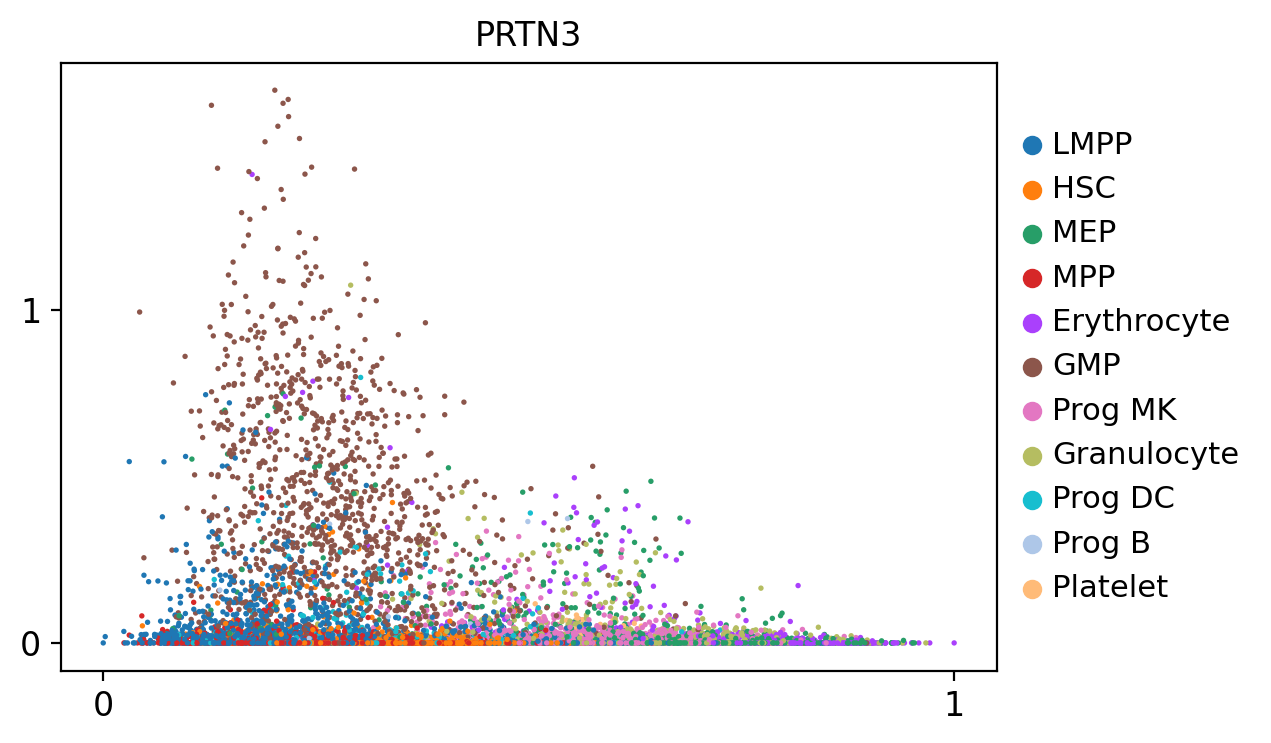

In [196]:
# for i in np.arange(0,phi_r.shape[1]):
#  adata.obs["phi"] = phi_r[:,i]
#  scv.pl.scatter(adata,y=adata.obs["phi"], x=adata.obs["latent_time"], color=['celltype']
#                ,legend_loc='right', title=gene_name)
scv.pl.scatter(adata,y=adata.layers["Mu"][:,gene_number], x=adata.obs["latent_time"], color=['celltype']
               ,legend_loc='right', title=gene_name)

In [ ]:
adata.layers["ATAC"] = alpha_atac
mv.dynamic_plot(adata, gene_list_, color_by='celltype',show_anchors=False, gene_time=False, axis_on=False, frame_on=False)

# KNN Classifier

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.manifold import TSNE

In [22]:
adata_ = adata[:,u_dot_atac.sum(axis=0) != 0]
#gene_list = np.intersect1d(adata_.var_names, adata_mv.var_names)
gene_list = np.intersect1d(gene_list, adata_mv.var_names)

In [23]:
len(gene_list)

240

In [25]:
def class_cu (adata, gene_list, key = 'celltype'):  
   G = len(gene_list)
   acc = np.zeros(G)
   cm = 0
   for w, gene_name in enumerate(gene_list):
   #for w,j in enumerate(x):

      
      adata.var[adata.var_names == gene_name]#['velocity_genes']
      gene_number = np.where(adata.var_names == gene_name)[0][0]

      u = adata.layers['unspliced'][:,gene_number].toarray()
      c = adata.layers['ATAC'][:,gene_number][:,np.newaxis]
      cu = np.concatenate((c, u), axis=1)

      X_train, X_test, y_train, y_test = train_test_split(cu, adata.obs[key].values, test_size = 0.30)
      classifier = KNeighborsClassifier( metric = 'euclidean')
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_test)
      cm += confusion_matrix(y_test, y_pred)
      ac = accuracy_score(y_test,y_pred)
      acc[w]=ac
   return acc , cm

In [26]:
def class_su (adata, gene_list, key = 'celltype'):  
   G = len(gene_list)
   acc = np.zeros(G)
   cm = 0
   for w, gene_name in enumerate(gene_list):
   #for w,j in enumerate(x):

      
      adata.var[adata.var_names == gene_name]#['velocity_genes']
      gene_number = np.where(adata.var_names == gene_name)[0][0]

      u = adata.layers['unspliced'][:,gene_number].toarray()
      s = adata.layers['spliced'][:,gene_number].toarray()
      su = np.concatenate((s, u), axis=1)

      X_train, X_test, y_train, y_test = train_test_split(su, adata.obs[key].values, test_size = 0.30)
      classifier = KNeighborsClassifier( metric = 'euclidean')
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_test)
      
      cm += confusion_matrix(y_test, y_pred)
      ac = accuracy_score(y_test,y_pred)
      acc[w]=ac
   return acc , cm

In [38]:

acc_, cm = class_cu (adata, gene_list, key = 'celltype')

In [ ]:
acc_mv, cm_mv = class_cu (adata_mv, gene_list, key = 'celltype')

In [ ]:
acc_su, cm_su = class_su (adata, gene_list, key = 'celltype')

In [59]:
np.savetxt(fig_path + "KNN_CRAK_Velo.csv", acc, delimiter=",")
np.savetxt(fig_path + "KNN_MultiVelo.csv", acc_mv, delimiter=",")
np.savetxt(fig_path + "KNN_su.csv", acc_su, delimiter=",")

In [84]:
acc_, cm = class_cu (adata, gene_list_, key = 'celltype')
acc_mv_, cm_mv = class_cu (adata_mv, gene_list_, key = 'leiden')
acc_su_, cm_su = class_su (adata, gene_list_, key = 'celltype')

data = {
    'CRAK-Velo': acc_,
    'MultiVelo':acc_mv_,
    'su':acc_su_
}

# Create a DataFrame from the dictionary, with genes as the row index
df = pd.DataFrame(data, index=gene_list_)

df = df.reset_index()


df = df.rename(columns={'index': 'Gene'})

#df.to_csv(fig_path+"three_genes_KNN.csv", index=False)

df
    

,Gene,CRAK-Velo,MultiVelo,su
0,HDC,0.247559,0.182941,0.213096
1,ADCY6,0.377657,0.165997,0.189833
2,STOM,0.323377,0.153935,0.182941


In [152]:
def cm_matrix(cm, adata, key = 'celltype', figsize=(8, 6)):    
    
    cell_type_labels = adata.obs[key].unique()
    sns.set(font_scale=1.2) 
    plt.figure(figsize=figsize)
    cm = (cm/len(gene_list)).astype(int)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=cell_type_labels, yticklabels=cell_type_labels)

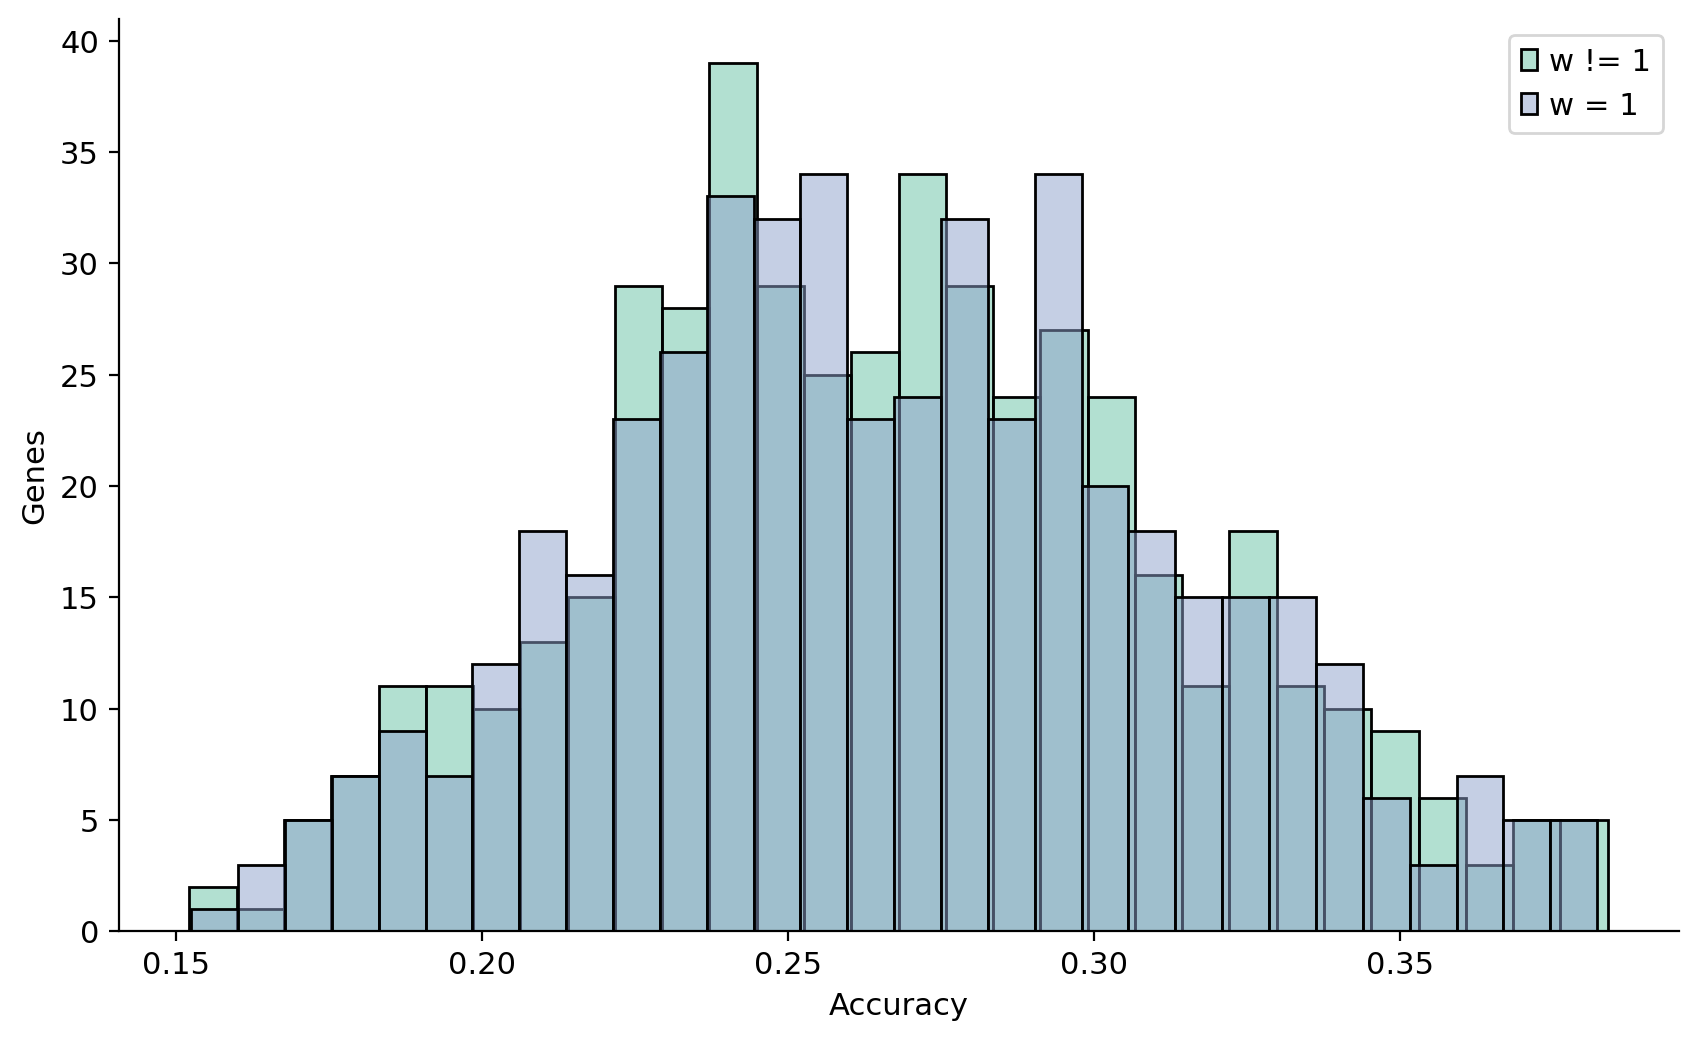

In [39]:
bins=30
alpha=0.5

colors = plt.get_cmap('Set2').colors
labels = ['w != 1','w = 1']#
plt.figure(figsize=(10, 6))
n = 0
sns.histplot(acc_, bins=bins, color=colors[n], label=labels[0], alpha=alpha, kde=False)
plot = sns.histplot(acc, bins=bins, color=colors[n+2], label=labels[1], alpha=alpha, kde=False)


plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)

plt.ylabel("Genes")
plt.xlabel("Accuracy")
plt.legend()


In [32]:
acc.mean() 


0.2684915278575531

In [33]:
acc_.mean()

0.268298870381007

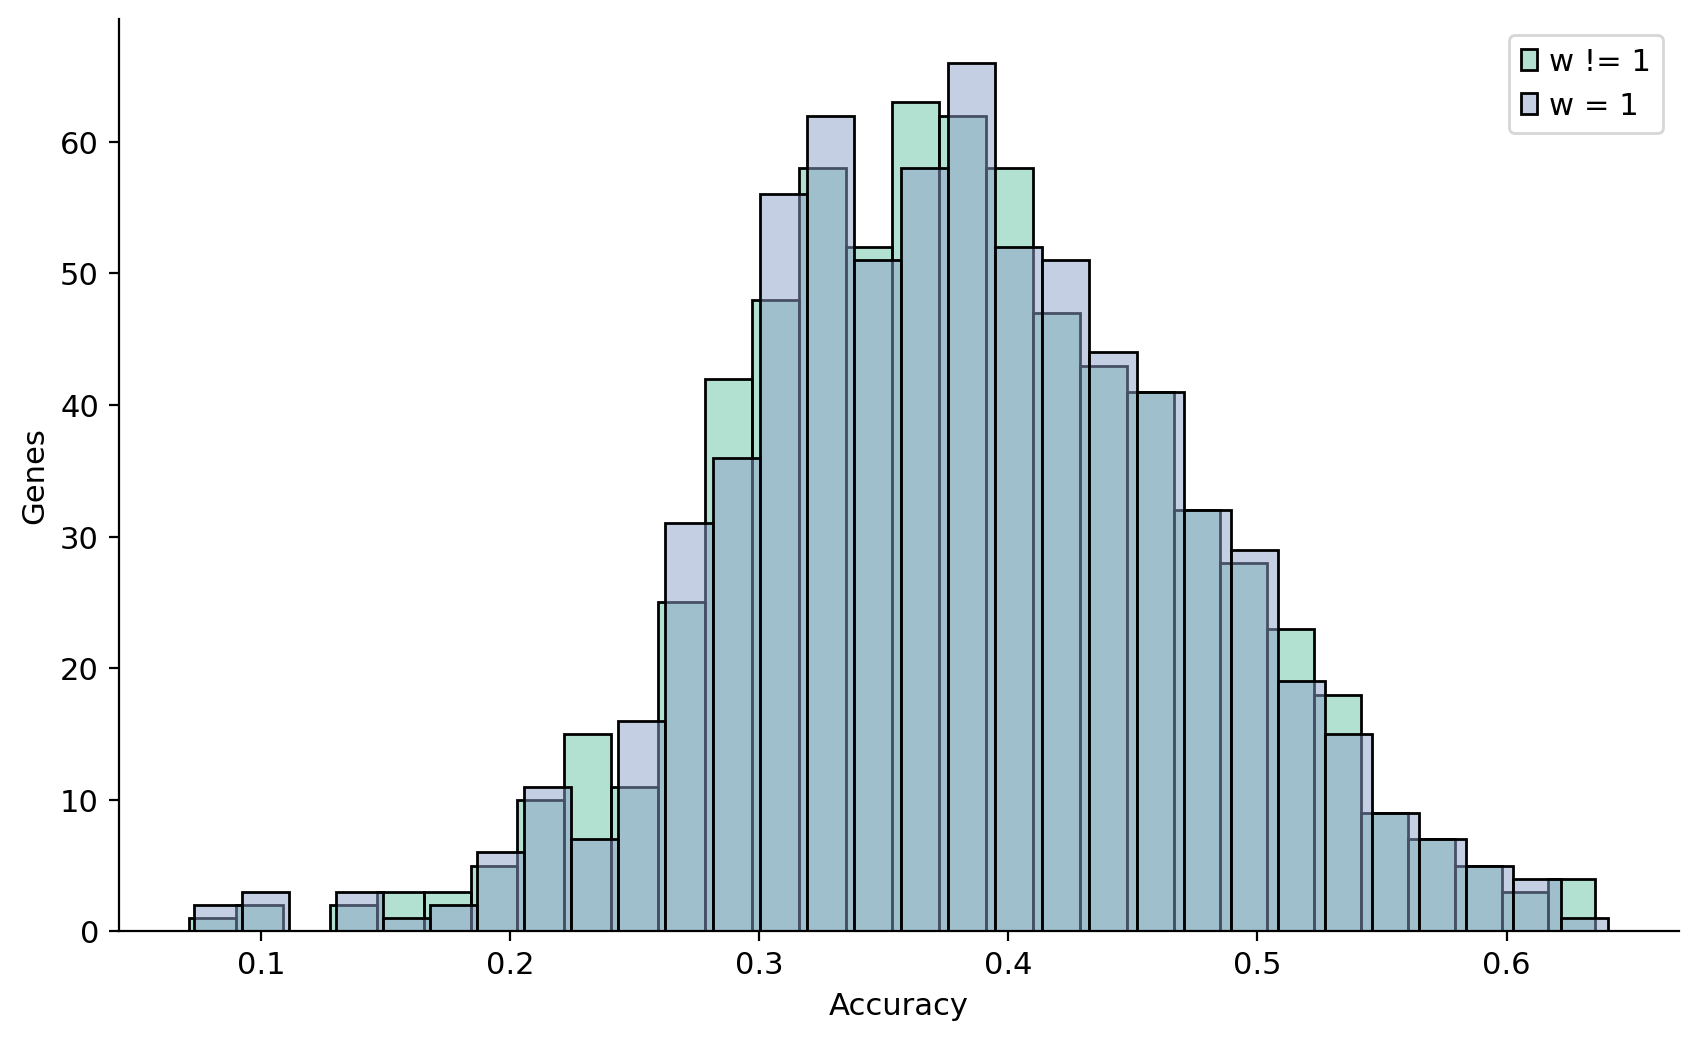

In [37]:
bins=30
alpha=0.5

colors = plt.get_cmap('Set2').colors
labels = ['w != 1','w = 1']#
plt.figure(figsize=(10, 6))
n = 0
sns.histplot(acc_, bins=bins, color=colors[n], label=labels[0], alpha=alpha, kde=False)
plot = sns.histplot(acc, bins=bins, color=colors[n+2], label=labels[1], alpha=alpha, kde=False)


plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)

plt.ylabel("Genes")
plt.xlabel("Accuracy")
plt.legend()


In [ ]:
# acc.mean() = 0.38241474147414733
# acc_.mean() = 0.38187156215621565

In [ ]:
bins=30
alpha=0.5

colors = plt.get_cmap('Set2').colors
labels = ['w != 1','w = 1']#
plt.figure(figsize=(10, 6))
n = 0
sns.histplot(acc_, bins=bins, color=colors[n], label=labels[0], alpha=alpha, kde=False)
plot = sns.histplot(acc, bins=bins, color=colors[n+2], label=labels[1], alpha=alpha, kde=False)


plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)

plt.ylabel("Genes")
plt.xlabel("Accuracy")
plt.legend()


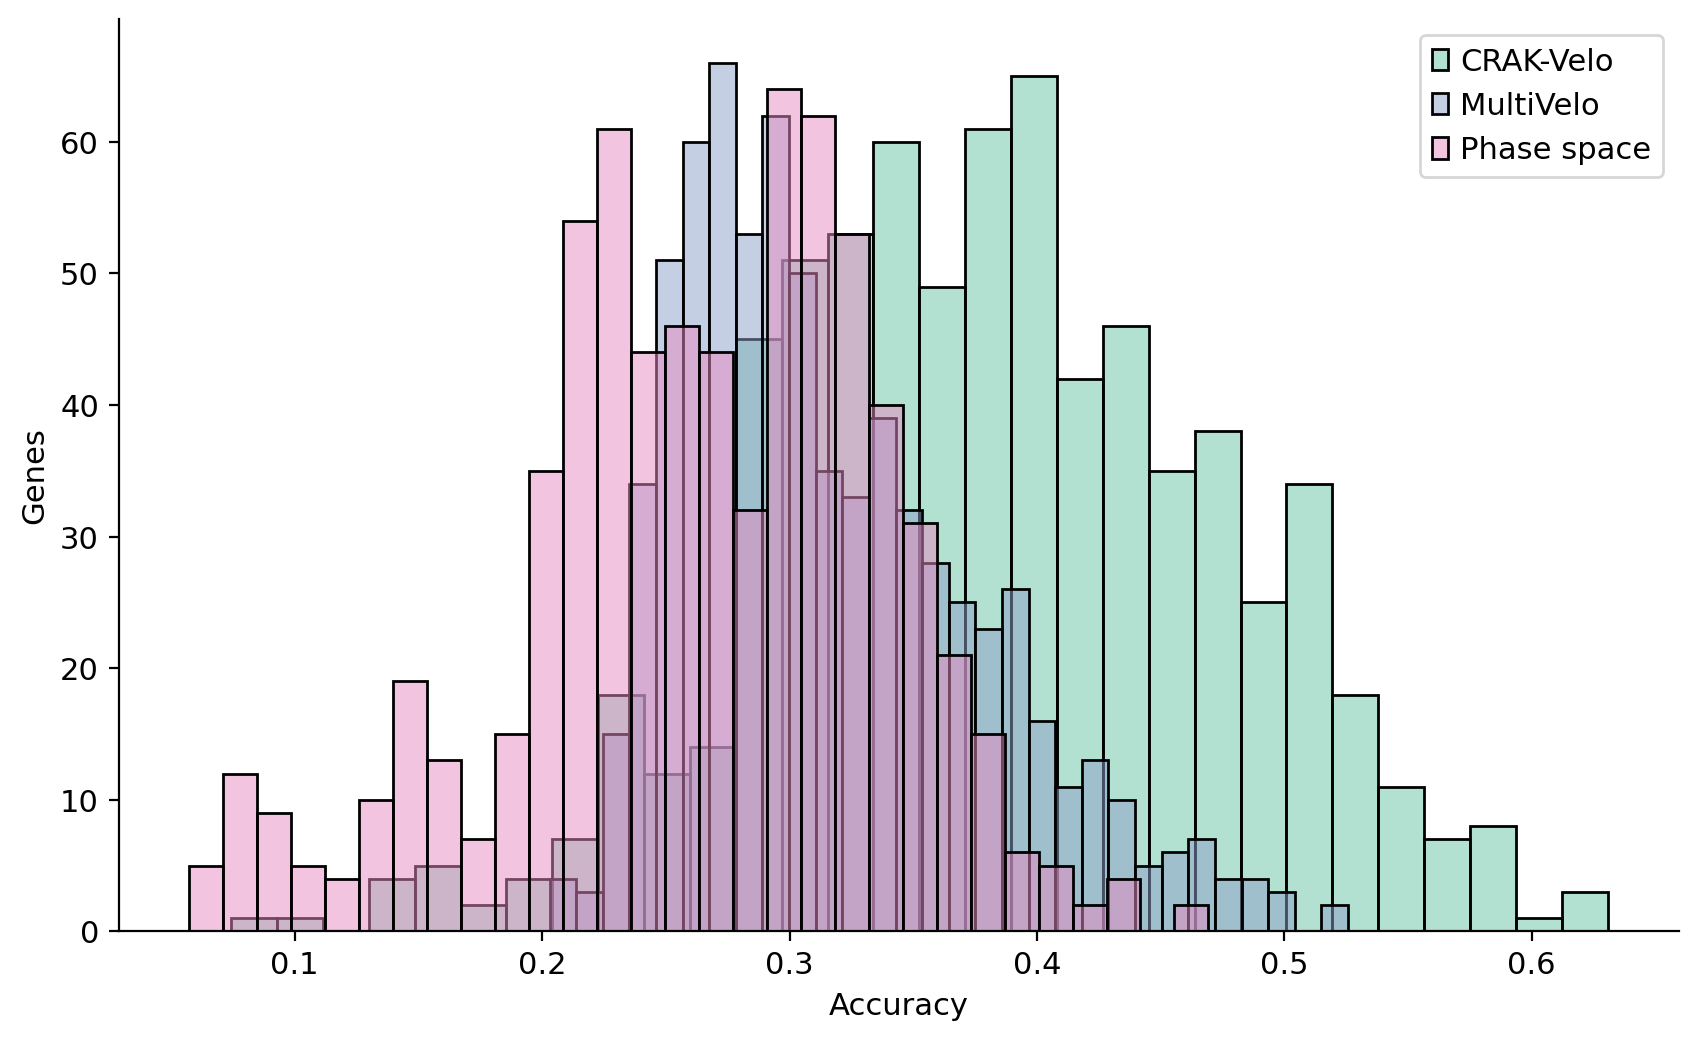

In [60]:
bins=30
alpha=0.5

colors = plt.get_cmap('Set2').colors
labels = ['CRAK-Velo', 'MultiVelo', 'Phase space']#
plt.figure(figsize=(10, 6))
n = 0
sns.histplot(acc, bins=bins, color=colors[n], label=labels[0], alpha=alpha, kde=False)
sns.histplot(acc_mv, bins=bins, color=colors[n+2], label=labels[1], alpha=alpha, kde=False)
plot = sns.histplot(acc_su, bins=bins, color=colors[n+3], label=labels[2], alpha=alpha, kde=False)
plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plt.ylabel("Genes")
plt.xlabel("Accuracy")
plt.legend()
plt.savefig(fig_path+'KNN_mouse_brain.png', dpi=300)
plt.savefig(fig_path+'KNN_mouse_brain.pdf', dpi=300)

In [158]:
gene_list_ = gene_list[np.where(acc>0.53)[0]]

In [52]:
# key = "T1"
# adata_T_unv = adata_unv[adata_unv.obs["celltype"].isin(trajectories[key])]
# adata_T = adata[adata.obs["celltype"].isin(trajectories[key])]
# adata_mv_T = adata_mv[adata_mv.obs["leiden"].isin(trajectories[key])]

In [ ]:
# def compute_alpha_unit(adata):
   
#     alpha_unit = np.zeros([adata.shape[0], adata.shape[1]])
#     u_dots = np.zeros([adata.shape[0], adata.shape[1]])
#     gene_names = adata.var_names#[adata.var['velocity_genes']]
#     for i, gene_name in enumerate(gene_names):
#         n = np.where(adata.var_names==gene_name)[0][0]
        
#         s = np.power(adata.obs["latent_time"]-adata.var["fit_t"][n],2)
#         s = np.exp(-1*adata.var["fit_a"][n]*s)
#         s = adata.var["fit_h"][n]*s+adata.var["fit_offset"][n]

#         s_dot = s*(adata.obs["latent_time"]-adata.var["fit_t"][n])*(-2*adata.var["fit_a"][n])

#         u = s_dot+adata.var["fit_gamma"][n]*s
#         u = u/adata.var["fit_beta"][n]
#         u = u + adata.var["fit_intercept"][n]

#         u_dot = (adata.obs["latent_time"]-adata.var["fit_t"][n])*(-2*adata.var["fit_a"][n])
#         u_dot = u_dot+adata.var["fit_gamma"][n]
#         u_dot = u_dot*s_dot
#         u_dot = u_dot-2*adata.var["fit_a"][n]*s
#         u_dot = u_dot/np.power(adata.var["fit_beta"][n],2)
#         u_dots[:,i] = u_dot
#         alpha = u_dot + adata.var["fit_beta"][n]*u
#         #adata.obs["alpha_{}".format(gene_name)] = alpha
#         alpha_unit[:,i] = alpha
#     return alpha_unit

In [37]:
import sys
import importlib

# Clear the module from cache
sys.modules.pop('supplement.fitting_genes_regions', None)
sys.modules.pop('pl.pl', None)

# Reload the module
importlib.import_module('pl.pl')
importlib.import_module('supplement.fitting_genes_regions')

#from pl.pl import gene_weights_plots, get_scatter_markers, region_dynamic_plot
from supplement.fitting_genes_regions import average_over_intervals, compute_alpha_atac, region_unspliced_kinetics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
